In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [59]:
data = pd.read_csv('/content/drive/My Drive/data/hanoi_quality.csv', index_col='date')

In [60]:
data

,pm25,pm10,o3,no2,so2,co
date,,,,,,
3/1/2019,76,1,15,36,7,7
3/2/2019,117,64,4,28,3,5
3/3/2019,10,64,1,22,16,5
3/4/2019,118,56,13,22,14,6
3/5/2019,2,34,15,21,6,6
...,...,...,...,...,...,...
5/28/2024,85,56,14,1,8,6
5/29/2024,58,50,13,1,8,6
5/30/2024,47,39,10,1,8,8


In [61]:
data.fillna(method='ffill', inplace=True)
scaler = MinMaxScaler()
data['pm25'] = scaler.fit_transform(data[['pm25']])

In [62]:
def create_sequences(data, seq_length=10):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 10
X, y = create_sequences(data['pm25'].values, seq_length)
X = X.reshape((X.shape[0], X.shape[1], 1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

In [63]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(seq_length, 1)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [64]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 10)                0         
                                                                 
 dense_12 (Dense)            (None, 128)               1408      
                                                                 
 dense_13 (Dense)            (None, 64)                8256      
                                                                 
 dense_14 (Dense)            (None, 1)                 65        
                                                                 
Total params: 9729 (38.00 KB)
Trainable params: 9729 (38.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [65]:
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), batch_size=12)

Epoch 1/50
112/112 [==============================] - 1s 4ms/step - loss: 0.0196 - val_loss: 0.0240
Epoch 2/50
112/112 [==============================] - 0s 2ms/step - loss: 0.0150 - val_loss: 0.0186
Epoch 3/50
112/112 [==============================] - 0s 3ms/step - loss: 0.0146 - val_loss: 0.0201
Epoch 4/50
112/112 [==============================] - 0s 3ms/step - loss: 0.0143 - val_loss: 0.0200
Epoch 5/50
112/112 [==============================] - 0s 3ms/step - loss: 0.0141 - val_loss: 0.0199
Epoch 6/50
112/112 [==============================] - 0s 3ms/step - loss: 0.0140 - val_loss: 0.0192
Epoch 7/50
112/112 [==============================] - 0s 3ms/step - loss: 0.0138 - val_loss: 0.0210
Epoch 8/50
112/112 [==============================] - 1s 8ms/step - loss: 0.0138 - val_loss: 0.0205
Epoch 9/50
112/112 [==============================] - 1s 8ms/step - loss: 0.0133 - val_loss: 0.0224
Epoch 10/50
112/112 [==============================] - 1s 7ms/step - loss: 0.0132 - val_loss: 0.0210

In [66]:
print('Actual value: %s'%str(y[-5:]))
print('Predict value:')
yhat = model.predict(X_test)
print(yhat)

Actual value: [0.38604651 0.26046512 0.20930233 0.21395349 0.44651163]
Predict value:
18/18 [==============================] - 0s 2ms/step
[[-0.00903992]
 [ 0.11249658]
 [ 0.46983206]
 [ 0.3501496 ]
 [ 0.1895443 ]
 [ 0.22981751]
 [ 0.13683856]
 [ 0.17646696]
 [ 0.19839698]
 [ 0.21256697]
 [ 0.1373635 ]
 [ 0.13135433]
 [ 0.16861837]
 [ 0.16766593]
 [ 0.20508137]
 [ 0.26356092]
 [ 0.31387872]
 [ 0.21072304]
 [ 0.15140228]
 [ 0.16733974]
 [ 0.1915877 ]
 [ 0.12777884]
 [ 0.10929066]
 [ 0.13183528]
 [ 0.06473255]
 [ 0.1051351 ]
 [ 0.13085148]
 [ 0.17562917]
 [ 0.11250098]
 [ 0.11268549]
 [ 0.20942436]
 [ 0.23565015]
 [ 0.2009546 ]
 [ 0.14105265]
 [ 0.14081031]
 [ 0.14653262]
 [ 0.27614248]
 [ 0.19910073]
 [ 0.17497298]
 [ 0.2282736 ]
 [ 0.30592635]
 [ 0.13348486]
 [ 0.15737548]
 [ 0.22604822]
 [ 0.24876258]
 [ 0.18693411]
 [ 0.29657468]
 [ 0.1608077 ]
 [ 0.15067814]
 [ 0.20737182]
 [ 0.1253533 ]
 [ 0.10251367]
 [ 0.13123512]
 [ 0.24954356]
 [ 0.32661512]
 [ 0.50995153]
 [ 0.462753  ]
 [ 0.5

In [67]:
def RMSE(yhat, y):
    return np.sqrt(np.mean((yhat - y)**2))

yhat = model.predict(X)
RMSE(yhat, y)

60/60 [==============================] - 0s 2ms/step


0.24647887882974115

In [68]:
yhat_inverse = scaler.inverse_transform(np.array(yhat).reshape(-1, 1))

In [69]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

rmse = np.sqrt(mean_squared_error(y, yhat))
mape = mean_absolute_percentage_error(y, yhat)
mae = mean_absolute_error(y, yhat)

print("RMSE:", rmse)
print("MAPE:", mape)
print("MAE:", mae)

RMSE: 0.11379963677322931
MAPE: 5131878811882.103
MAE: 0.07894083133736858


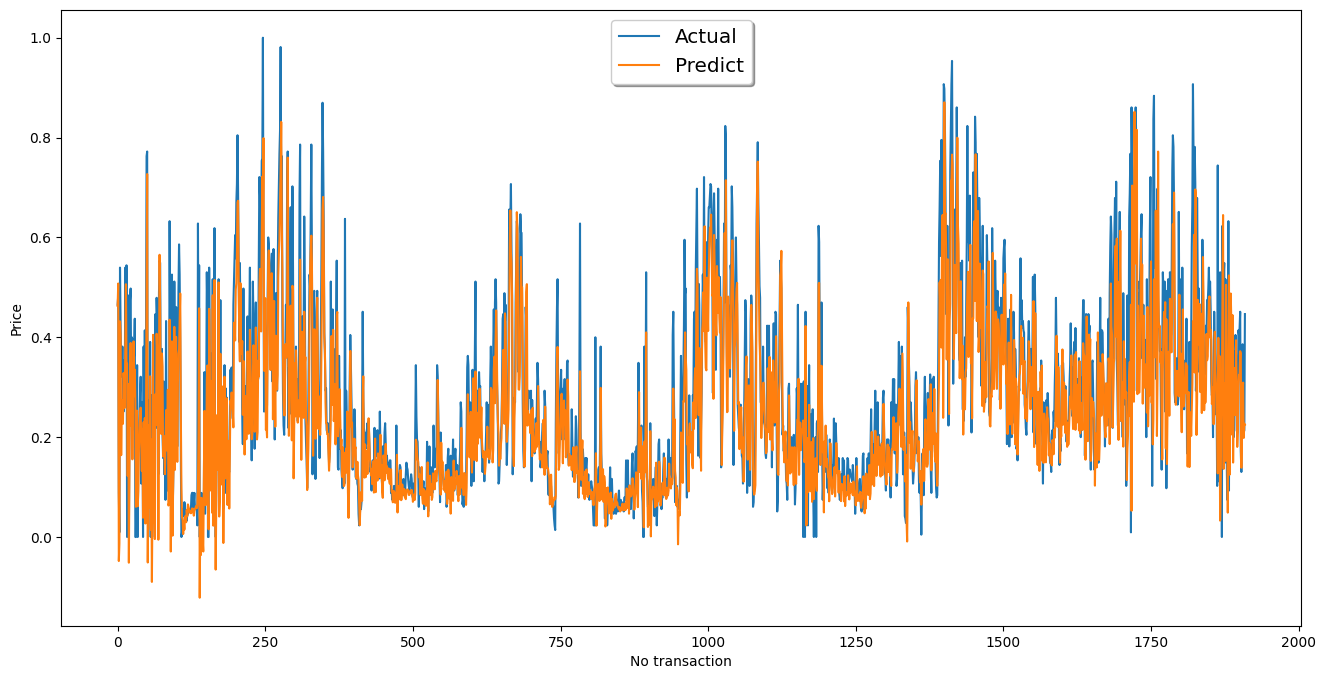

In [70]:
def plt_graph(y, yhat):
    plt.figure(figsize = (16, 8))
    plt.plot(y, label = 'Actual')
    plt.plot(yhat, label = 'Predict')
    plt.xlabel('No transaction')
    plt.ylabel('Price')
    legend = plt.legend(loc = 'upper center', shadow = True, fontsize = 'x-large')


plt_graph(y, yhat)


In [71]:
# Predict the next 90 days PM2.5 values
last_sequence = X_test[-1]
predictions = []
current_sequence = last_sequence

for _ in range(90):
    next_value = model.predict(current_sequence[np.newaxis, :, :])[0, 0]
    predictions.append(next_value)
    current_sequence = np.append(current_sequence[1:], [[next_value]], axis=0)

predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
print("Next 90 days PM2.5 predictions:", predictions.flatten())

1/1 [==============================] - 0s 25ms/step
Next 90 days PM2.5 predictions: [50.37105   43.94646   55.44836   53.0297    34.69966   28.828592
 37.692398  40.573074  35.75383   32.04649   28.361475  21.621197
 18.098492  24.074697  23.980484  20.883383  20.362242  19.083055
 16.088694  16.510845  18.665579  17.022892  16.085949  16.9059
 15.736481  14.678604  15.584121  15.24556   14.212944  14.764061
 15.002139  14.166915  14.284557  14.572683  13.95294   13.900047
 14.321245  14.005645  13.774493  14.073694  13.950852  13.696017
 13.911015  13.927395  13.68414   13.783685  13.879105  13.704821
 13.719416  13.830065  13.717788  13.678863  13.783155  13.7344265
 13.670288  13.743069  13.736863  13.672021  13.71466   13.735048
 13.68091   13.695412  13.726569  13.690387  13.686371  13.7169485
 13.697441  13.683008  13.7073    13.701759  13.684219  13.699604
 13.702874  13.687019  13.694314  13.702105  13.690321  13.691299
 13.700039  13.693017  13.690207  13.697723  13.694797  13

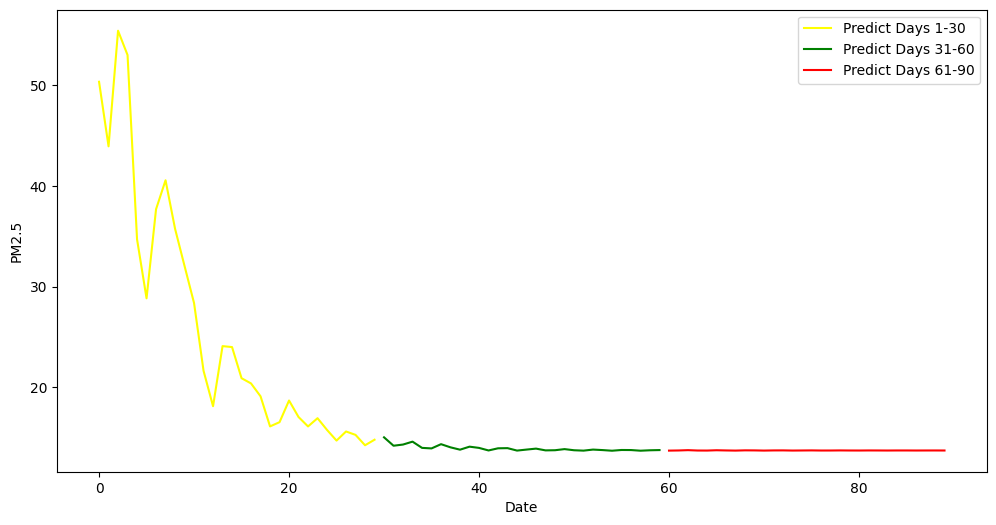

In [72]:
plt.figure(figsize=(12, 6))

dates = np.arange(1, 91)
df = pd.DataFrame({'Date': dates, 'predictions': predictions.flatten()}) # Flatten predictions to 1D array

plt.plot(df['predictions'][:30], color='yellow', label='Predict Days 1-30')
plt.plot(df['predictions'][30:60], color='green', label='Predict Days 31-60')
plt.plot(df['predictions'][60:], color='red', label='Predict Days 61-90')

# Adding labels and legend
plt.xlabel('Date')
plt.ylabel('PM2.5')
plt.legend()

# Show plot
plt.show()